In [1]:
library(tidyverse)
library(igraph)

source('../utils/plottingUtilities.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

  

In [2]:
# from this, we really just need late$template
load('../data/lateData.Rdata')

In [3]:
# load irf fits
load('../model_fits/irf_fits_2021-06-18/irfSpatialFit_eye_set12pp.Rdata')

In [4]:
ls()

[1] "fit"             "generateImage"   "getNodeImages"   "getNodeLabel"   
 [5] "getNodePosition" "img2Color"       "late"            "mapLate2Early"  
 [9] "multiplot"       "overlayImage"    "overlayImages"   "plot_all_PPs"   
[13] "plotGroupImg"    "plotImg"         "plotPP"          "shiftHoriz"     
[17] "shiftImg"        "shiftVert"       "test.id"         "tf"             
[21] "train.id"        "x.late"          "y.late"

# get interactions

In [5]:
interactions <- fit$interaction[, 1]

In [6]:
interactions

[1] "eya_a+_LanA-"      "eya_a+_srp_b-"     "CG32486-_eya_a+"  
 [4] "Alhambra+_eya_a+"  "eya_a+_rib-"       "eya_a+_Prosbeta1-"
 [7] "chif-_eya_a+"      "CG10176-_eya_a+"   "eya_a+_Rab23-"    
[10] "eya_a-_Optix+"     "Abd-_eya_a+"       "CG5385-_eya_a+"   
[13] "apt-_eya_a-"

In [7]:
# first gene
interaction1 <- gsub('[+, -]_.*', "", interactions)
print(interaction1)

sign1 <- substr(interactions,nchar(interaction1)+1,nchar(interaction1)+1)

 [1] "eya_a"    "eya_a"    "CG32486"  "Alhambra" "eya_a"    "eya_a"   
 [7] "chif"     "CG10176"  "eya_a"    "eya_a"    "Abd"      "CG5385"  
[13] "apt"     


In [8]:
# second_gene
interaction2 <- gsub('.*[+, -]_', "", interactions)

sign2 <- substr(interaction2,nchar(interaction2),nchar(interaction2)) 

interaction2 <- substr(interaction2,1,nchar(interaction2)-1) 

In [9]:
interaction2

[1] "LanA"      "srp_b"     "eya_a"     "eya_a"     "rib"       "Prosbeta1"
 [7] "eya_a"     "eya_a"     "Rab23"     "Optix"     "eya_a"     "eya_a"    
[13] "eya_a"

In [10]:
# just check for my sanity regex logic is correct
all(interactions == paste0(interaction1, sign1, '_', interaction2, sign2))

[1] TRUE

# Plot a few interactoins

In [11]:
indx <- seq(1, 6)

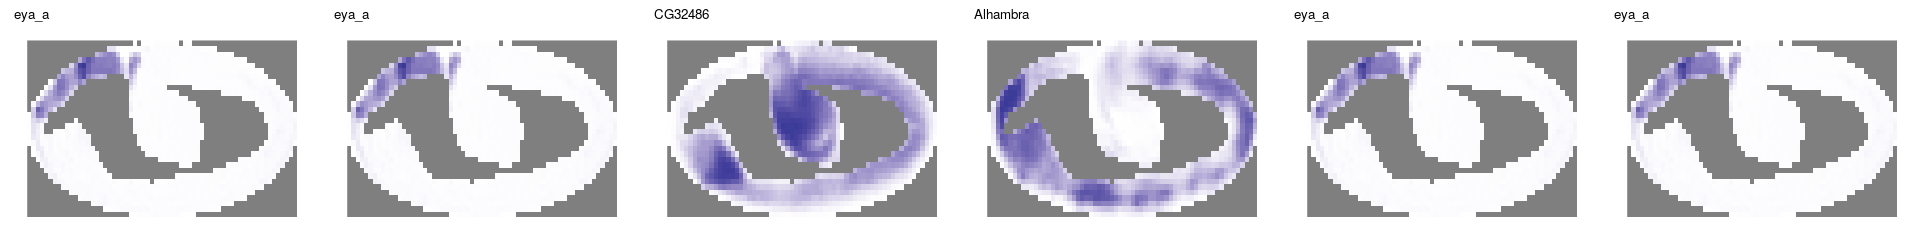

In [12]:
p <- list()

for(i in 1:length(indx)){
    gene <- interaction1[indx[i]]
    p[[i]] <- plotImg(x.late[, gene], late$template, FALSE, gene)       
}

options(repr.plot.width = 16, repr.plot.height = 2)
multiplot(plotlist = p, cols = length(indx))


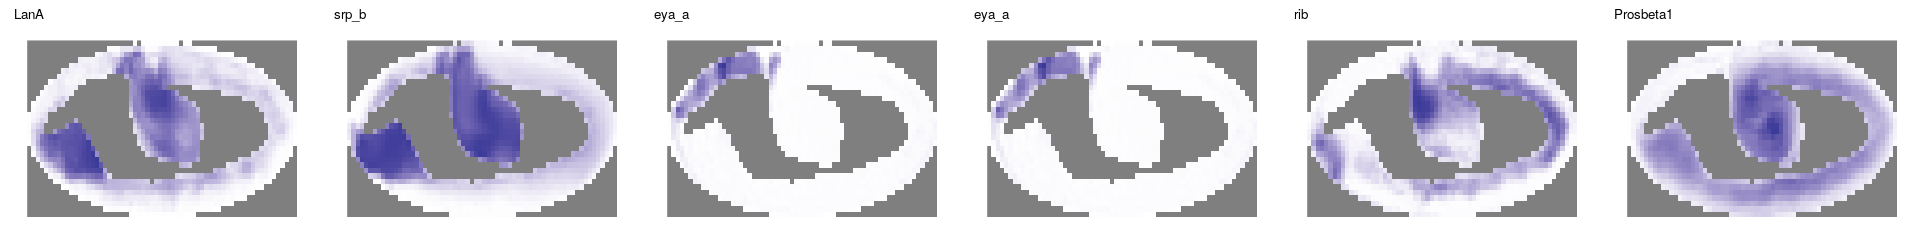

In [13]:
p <- list()

for(i in 1:length(indx)){
    gene <- interaction2[indx[i]]
    p[[i]] <- plotImg(x.late[, gene], late$template, FALSE, gene)       
}

multiplot(plotlist = p, cols = length(indx))


In [14]:
interactions[indx]

[1] "eya_a+_LanA-"      "eya_a+_srp_b-"     "CG32486-_eya_a+"  
[4] "Alhambra+_eya_a+"  "eya_a+_rib-"       "eya_a+_Prosbeta1-"

# Construct graph

In [15]:
unique.genes <- unique(c(interaction1, interaction2))

In [16]:
network.mat <- matrix(rep(0, length(unique.genes)**2), ncol = length(unique.genes))
colnames(network.mat) <- unique.genes
rownames(network.mat) <- unique.genes

In [17]:
stability.scores <- fit$interaction[, 'stability'] + 1e-6

In [18]:
edges <- rep(0, length(interaction1))
for(i in 1:length(interaction1)){
    gene1 <- interaction1[i]
    gene2 <- interaction2[i]
    
    if(sign1[i] == sign2[i]){
        network.mat[gene1, gene2] <- 1 * stability.scores[i]
        network.mat[gene2, gene1] <- 1 * stability.scores[i]
    }
    if(sign1[i] != sign2[i]){
        network.mat[gene1, gene2] <- -1 * stability.scores[i]
        network.mat[gene2, gene1] <- -1 * stability.scores[i]
    }
        
}

In [19]:
iRF.graph <- graph_from_adjacency_matrix(network.mat, weighted = TRUE,
                                   diag = FALSE, 
                                    mode = 'upper')


In [20]:
la <- layout_with_dh(iRF.graph)

In [21]:
E(iRF.graph)$color[E(iRF.graph)$weight > 0] <- 'red'
E(iRF.graph)$color[E(iRF.graph)$weight < 0] <- 'blue'

In [22]:
E(iRF.graph)$width <- abs(E(iRF.graph)$weight) * 10

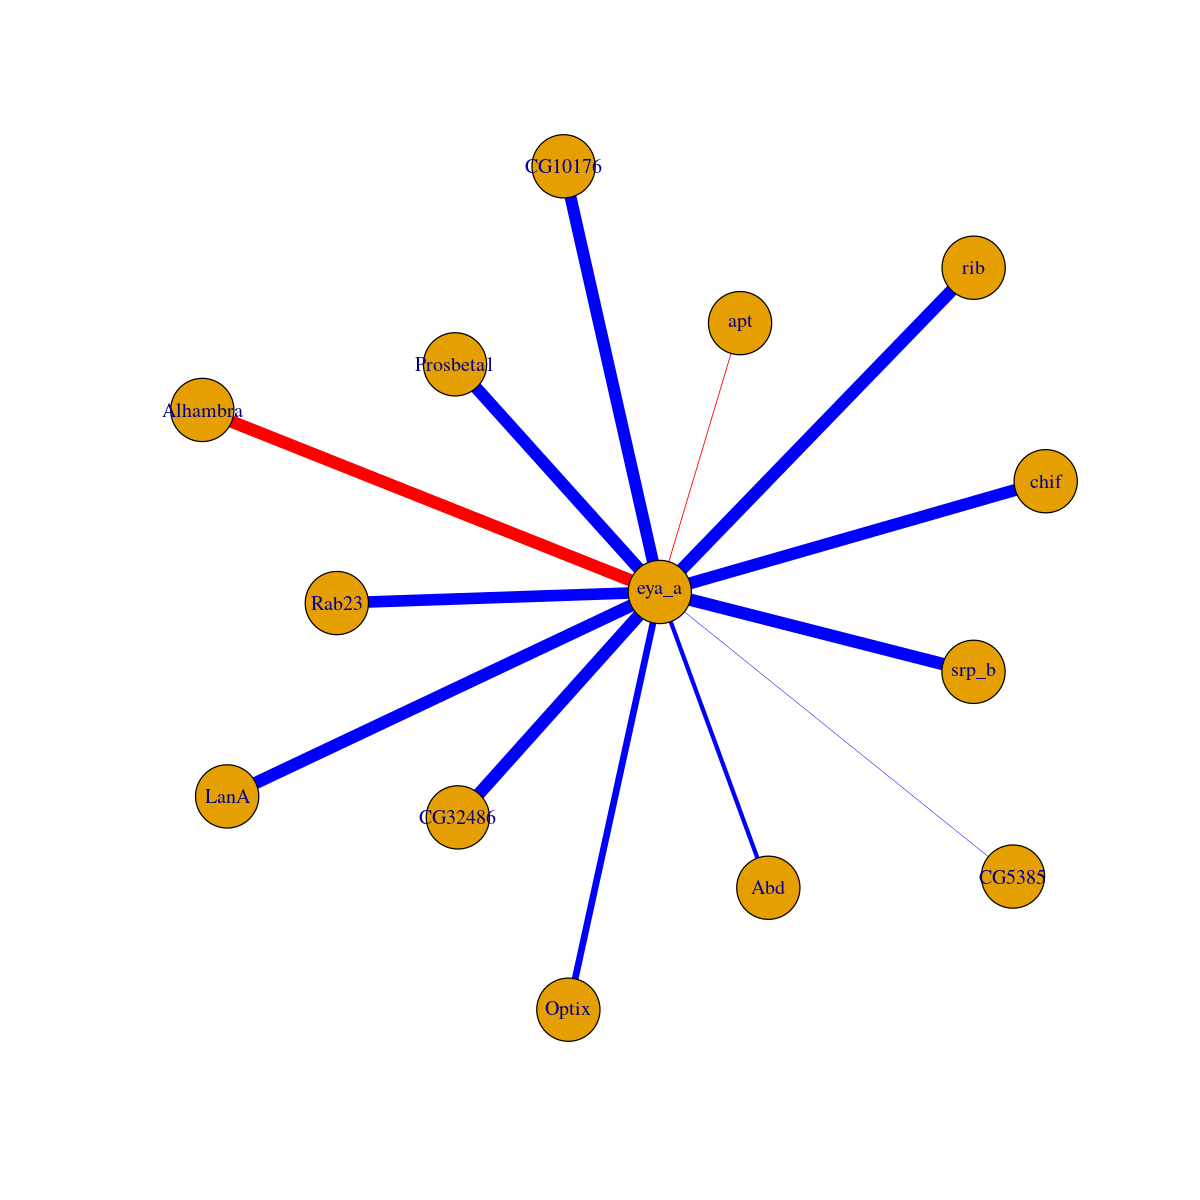

In [23]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot(iRF.graph, layout = la, edge.width=E(iRF.graph)$width)

In [24]:
interactions

[1] "eya_a+_LanA-"      "eya_a+_srp_b-"     "CG32486-_eya_a+"  
 [4] "Alhambra+_eya_a+"  "eya_a+_rib-"       "eya_a+_Prosbeta1-"
 [7] "chif-_eya_a+"      "CG10176-_eya_a+"   "eya_a+_Rab23-"    
[10] "eya_a-_Optix+"     "Abd-_eya_a+"       "CG5385-_eya_a+"   
[13] "apt-_eya_a-"